### Helpers

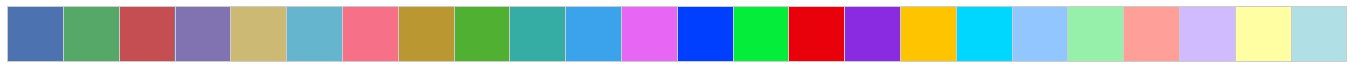

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import scoring
from IPython.display import display

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [2]:
N_STATIONS = 4

# train cols
unused_train_cols = ['particle_type', 'kinWeight', 'sWeight']
train_cols = ['label', 'weight']
ALL_TRAIN_COLS = train_cols + unused_train_cols

# original cols
x_cols = ['MatchedHit_X[%i]' % i for i in range(N_STATIONS)]
y_cols = ['MatchedHit_Y[%i]' % i for i in range(N_STATIONS)]
z_cols = ['MatchedHit_Z[%i]' % i for i in range(N_STATIONS)]
xy_cols = x_cols + y_cols
xyz_cols = x_cols + y_cols + z_cols
dx_cols = ['MatchedHit_DX[%i]' % i for i in range(N_STATIONS)]
dy_cols = ['MatchedHit_DY[%i]' % i for i in range(N_STATIONS)]
dz_cols = ['MatchedHit_DZ[%i]' % i for i in range(N_STATIONS)]
dxyz_cols = dx_cols + dy_cols + dz_cols

ex_cols = ['Lextra_X[%i]' % i for i in range(N_STATIONS)]
ey_cols = ['Lextra_Y[%i]' % i for i in range(N_STATIONS)]
exy_cols = ex_cols + ey_cols
edx_cols = ['Mextra_DX2[%i]' % i for i in range(N_STATIONS)]
edy_cols = ['Mextra_DY2[%i]' % i for i in range(N_STATIONS)]
edxy_cols = edx_cols + edy_cols

t_cols = ['MatchedHit_T[%i]' % i for i in range(N_STATIONS)]
dt_cols = ['MatchedHit_DT[%i]' % i for i in range(N_STATIONS)]

hit_type_cols = ['MatchedHit_TYPE[%i]' % i for i in range(N_STATIONS)]
mom_cols = ['P', 'PT']
hit_stats_cols = ['FOI_hits_N', 'NShared', 'ndof']

ncl_cols = ['ncl[%i]' % i for i in range(N_STATIONS)]
avg_cs_cols = ['avg_cs[%i]' % i for i in range(N_STATIONS)]

# foi cols
foi_xyz_cols = ["FOI_hits_X", "FOI_hits_Y", "FOI_hits_Z"]
foi_dxyz_cols = ["FOI_hits_DX", "FOI_hits_DY", "FOI_hits_DZ"]
foi_ts_cols = ["FOI_hits_T", "FOI_hits_DT", "FOI_hits_S"]
foi_cols = foi_xyz_cols + foi_dxyz_cols + foi_ts_cols

# derivative cols
pca_x_cols = ['PCA_X[%i]' % i for i in range(N_STATIONS)]
pca_y_cols = ['PCA_Y[%i]' % i for i in range(N_STATIONS)]
pca_z_cols = ['PCA_Z[%i]' % i for i in range(N_STATIONS)]
pca_xyz_cols = pca_x_cols + pca_y_cols + pca_z_cols

nerr_x_cols = ['NErr_X[%i]' % i for i in range(N_STATIONS)]
nerr_y_cols = ['NErr_Y[%i]' % i for i in range(N_STATIONS)]
nerr_xy_cols = nerr_x_cols + nerr_y_cols

da_cols = ['DAngle[%d]' % i for i in range(1, 4)]
is_muon_cols = ['IsMuonTight']
prob_hit_detector_cols = ['ProbHit[%i]' % i for i in range(N_STATIONS)]
err_cols = ['ErrMSE', 'Chi2Quantile']

SIMPLE_FEATURE_COLS = xyz_cols + dxyz_cols + exy_cols + edxy_cols + t_cols + dt_cols + hit_type_cols + mom_cols + hit_stats_cols + ncl_cols + avg_cs_cols
ARR_FEATURE_COLS = foi_cols

In [3]:
len(SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS + ALL_TRAIN_COLS)

79

### Convert csv to pickles

In [56]:
class DatasetMetaData:
    def __init__(self, origin_csv_filenames, chunk_filenames_pattern, origin_col_set):
        self.origin_csv_filenames = origin_csv_filenames
        self.chunk_filenames_pattern = chunk_filenames_pattern
        self.origin_col_set = origin_col_set
        self.is_test = 'test_' in chunk_filenames_pattern

meta_train = DatasetMetaData(
    origin_csv_filenames=['data/train_part_1_v2.csv.gz', 'data/train_part_2_v2.csv.gz'],
    chunk_filenames_pattern='data/train_{label}_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS + ALL_TRAIN_COLS
)
meta_pub_test = DatasetMetaData(
    origin_csv_filenames=['data/test_public_v2.csv.gz'],
    chunk_filenames_pattern='data/test_pub_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS
)
meta_pvt_test = DatasetMetaData(
    origin_csv_filenames=[],
    chunk_filenames_pattern='data/test_pvt_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS
)

In [25]:
from itertools import repeat

class CsvDataReader:
    def __init__(self):
        self.na_values = ['-9999.0', '255']
        self.int_dtype = np.int32
        self.float_dtype = np.float32
    
    def get_data(self, filenames, usecols, chunk_size=25000):        
        for filename in filenames:
            data_generator = pd.read_csv(
                filename, usecols=usecols, chunksize=chunk_size, #nrows=400000,
                na_values=self.na_values, na_filter=False, 
                converters=self._get_converters(), dtype=self._get_types()
            )
            for data in data_generator:
                yield data

    def _get_converters(self):
        def parse_float_array(line):
            return np.fromstring(line[1:-1], sep=" ", dtype=self.float_dtype)

        def parse_int_array(line):
            return np.fromstring(line[1:-1], sep=" ", dtype=self.int_dtype)
    
        converters = dict(zip(ARR_FEATURE_COLS, repeat(parse_float_array)))
        converters[foi_ts_cols[-1]] = parse_int_array
        return
    
    def _get_types(self):
        types = dict(zip(SIMPLE_FEATURE_COLS + ALL_TRAIN_COLS, repeat(self.float_dtype)))
        for col in unused_train_cols[:1] + train_cols[:1] + hit_stats_cols + ncl_cols + hit_type_cols:
            types[col] = self.int_dtype
        return types;

In [47]:
class DataBuffer:
    def __init__(self):
        self._frames = []
        self._chunk_counter = 0
    
    def slice_and_append(self, frame):
        self._frames.append(frame)
    
    def store_chunk(self, chunk_size, filename_pattern):
        chunk, chunk_ind = self._cut_chunk(chunk_size)
        for group_key, col_group in self._col_groups:
            filename = self._generate_chunk_filename(filename_pattern, group_key, chunk_ind)
            chunk.loc[:, col_group].to_pickle(filename)
    
    def _cut_chunk(self, chunk_size):
        data = pd.concat(self._frames, axis=0, ignore_index=True) if len(self._frames) > 1 else self._frames[0]
        chunk = data.iloc[:chunk_size, :]
        tail = data.iloc[chunk_size:, :]
        chunk_ind = self._chunk_counter
        
        self._frames = [tail]
        self._chunk_counter += 1
        return chunk, chunk_ind
    
    @property
    def nrows(self):
        return sum([len(frame.index) for frame in self._frames])
    
    @property
    def _col_groups(self):
        return col_groups[:-1]
    
    def _generate_chunk_filename(self, filename_pattern, group_key, chunk_ind):
        return filename_pattern.format(group=group_key, ind=chunk_ind)
    
class ClassDataBuffer(DataBuffer):
    def __init__(self, label, label_key):
        super(ClassDataBuffer, self).__init__()
        self._label = label
        self._label_key = label_key
        
    def slice_and_append(self, frame):
        self._frames.append(frame.loc[frame.label == self._label, :])
    
    @property
    def _col_groups(self):
        return col_groups
    
    def _generate_chunk_filename(self, filename_pattern, group_key, chunk_ind):
        return filename_pattern.format(label=self._label_key, group=group_key, ind=chunk_ind)
    
class PickleDataWriter:
    def __init__(self, filename_pattern, chunk_size=50000):
        self._filename_pattern = filename_pattern
        self._chunk_size = chunk_size
        self._is_test = 'test' in filename_pattern
        self._stored = 0
    
    def store_chunkified(self, dataframes_stream):
        buffers = [DataBuffer()] if self._is_test else [ClassDataBuffer(i, label_prefixes[i]) for i in range(2)]
        for data in dataframes_stream:
            for buffer in buffers:
                buffer.slice_and_append(data)
                self._try_offload_chunks(buffer)

        for buffer in buffers:
            self._try_offload_chunks(buffer, force=True)

    def _try_offload_chunks(self, buffer, force=False):
        while buffer.nrows > self._chunk_size or (force and buffer.nrows > 0):
            buffer.store_chunk(self._chunk_size, self._filename_pattern)    
            self._inc_stored()
            
    def _inc_stored(self):
        self._stored += self._chunk_size
        if self._stored % 200000 == 0:
            print('Stored: {0}M'.format(self._stored / 1000000.))
        
col_groups = list(zip(['sf', 'af', 'tr'], [SIMPLE_FEATURE_COLS, ARR_FEATURE_COLS, ALL_TRAIN_COLS]))
label_prefixes = ['L0', 'L1']

In [55]:
%%time
def convert_dataset(data_set_meta: DatasetMetaData):
    dataframes_stream = CsvDataReader().get_data(data_set_meta.origin_csv_filenames, data_set_meta.origin_col_set)
    PickleDataWriter(data_set_meta.chunk_filenames_pattern).store_chunkified(dataframes_stream)
    
convert_dataset(meta_pvt_test)

Wall time: 0 ns


### Read from pickle chunks

In [58]:
class DataBuffer:
    def __init__(self):
        self._frames = []
    
    def append(self, frame):
        self._frames.append(frame)
    
    def cut(self, nrows):
        nrows = min(nrows, self.nrows)
        merged = self._merge_frames()
        head = merged.iloc[:nrows, :]
        tail = merged.iloc[nrows:, :]
        
        self._frames = [tail]
        return head, nrows
    
    def _merge_frames(self):
        if len(self._frames) > 1:
            merged = pd.concat(self._frames, axis=0, ignore_index=True)
            self._frames = [merged]
        return self._frames[0]
    
    @property
    def nrows(self):
        return sum([len(frame.index) for frame in self._frames])
    
    @property
    def is_empty(self):
        return self.nrows == 0

In [65]:
class DataTank:
    def __init__(self, max_volume, callback_on_full):
        self._max_volume = max_volume
        self._buffer = DataBuffer()
        self._on_full = callback_on_full
    
    def add(self, frame):
        self._buffer.append(frame)
        flushed = 0
        while self._is_full():
            flushed += self.flush(self)
        return flushed
        
    def flush(self):
        if self._buffer.is_empty:
            return 0
        flushed_data, flushed_vol = self._buffer.cut(self._max_volume)
        self._on_full(flushed_data)
        return flushed_vol
    
    def _is_full(self):
        return self._buffer.nrows >= self._max_volume

In [68]:
class TestDatasetHelper:
    def __init__(self, filename_pattern):
        self._filename_pattern = filename_pattern

    def filter_frame(frame):
        return frame
        
    def get_col_groups(self):
        return col_groups[:-1]
        
    def generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(group=group_key, ind=chunk_ind)
    

class TrainDatasetHelper:
    def __init__(self, filename_pattern, label, label_key):
        self._filename_pattern = filename_pattern
        self._label = label
        self._label_key = label_key
        
    def filter_frame(frame):
        return frame.loc[frame.label == self._label, :]
        
    def get_col_groups(self):
        return col_groups[:-1]
        
    def generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(label=self._label_key, group=group_key, ind=chunk_ind)

In [70]:
class PickleDataWriter:
    def __init__(self, filename_pattern, helper, chunk_size):
        self._filename_pattern = filename_pattern
        self._helper = helper
        self._data_tank = DataTank(max_volume=chunk_size, callback_on_full=self._flush_chunk)
        self._chunk_index = 0
    
    def store(self, frame):
        filtered_frame = self._helper.filter_frame(frame)
        return self._data_tank.add(filtered_frame)
        
    def flush(self):
        return self._data_tank.flush()
    
    def _flush_chunk(self, chunk):
        self._store_chunk(chunk, self._chunk_index)
        self._chunk_index += 1
        
    def _store_chunk(self, chunk, chunk_index):
        for group_key, col_group in self._helper.get_col_groups():
            filename = self._helper.generate_chunk_filename(group_key, chunk_index)
            chunk.loc[:, col_group].to_pickle(filename)

In [59]:
import os.path

class PickleDataReader:
    def __init__(self, filename_pattern, helper):
        self._filename_pattern = filename_pattern
        self._helper = helper
        self._result = None
        
    def read(self, nrows, cols):
        data_tank = DataTank(nrows, self._set_read_result)
        for frame in self._read_chunks(cols):
            if data_tank.add(frame) > 0:
                return self._result

        data_tank.flush()
        return self._result
        
    def _read_chunks(self, cols):
        chunk_index = 0
        while True:
            frame = self._read_chunk(chunk_index, cols)
            if frame is None:
                break
            
            yield frame
            chunk_index += 1
            
    def _set_read_result(self, data):
        self._result = data
    
    def _read_chunk(self, chunk_index, cols):
        chunk_parts = []
        for group_key, col_group in self._helper.get_col_groups():
            cols_ = list(set(col_group) & set(cols))
            if not cols_:
                continue
            
            filename = self._helper.generate_chunk_filename(group_key, chunk_index)
            if not os.path.exists(filename):
                return None
            
            chunk_part = pd.read_pickle(filename).loc[:, cols_]
            chunk_parts.append(chunk_part)
            
        return pd.concat(chunk_parts, axis=0)
    
class PickleDataContainer:
    def __init__(self, filename_pattern, chunk_size=50000):
        self._filename_pattern = filename_pattern
        self._chunk_size = chunk_size
        self._is_test = 'test' in filename_pattern
        self._stored = 0
    
    def store_chunkified(self, dataframes_stream):
        containers = [PickleDataContainer()] if self._is_test else [ClassDataBuffer(i, label_prefixes[i]) for i in range(2)]
        for data in dataframes_stream:
            for buffer in buffers:
                buffer.slice_and_append(data)
                self._try_offload_chunks(buffer)

        for buffer in buffers:
            self._try_offload_chunks(buffer, force=True)

    def _try_offload_chunks(self, buffer, force=False):
        while buffer.nrows > self._chunk_size or (force and buffer.nrows > 0):
            buffer.store_chunk(self._chunk_size, self._filename_pattern)    
            self._inc_stored()
            
    def _inc_stored(self):
        self._stored += self._chunk_size
        if self._stored % 200000 == 0:
            print('Stored: {0}M'.format(self._stored / 1000000.))
    
# def read_dataset(data_set_meta: DatasetMetaData, nrows, cols, class_proportions):
    

SyntaxError: invalid syntax (<ipython-input-59-af170f6c1043>, line 13)

In [59]:
class PickleDataReader:
    def __init__(self, filename_pattern):
        self._filename_pattern = filename_pattern
        self._buffer = DataBuffer()
        self._chunk_index = 0
    
    def read(self, nrows):
        while not self._contains(nrows):
            frame = self._read_chunk(self._chunk_index)
            if frame is None:
                break

            self._buffer.append(frame)
            self._chunk_index += 1
        
        return self._buffer.cut(nrows) if not self._buffer.is_empty
    
    def _try_offload_chunks(self):
        offloaded = 0
        while self._contains(self._chunk_size):
            chunk = self._buffer.cut(self._chunk_size)
            self._store_chunk(chunk, self._chunk_index)
            
            self._chunk_index += 1
            offloaded += self._chunk_size
        return offloaded
            
    def _contains(self, nrows):
        return self._buffer.nrows >= nrows
    
    def _store_chunk(self, chunk, chunk_index):
        for group_key, col_group in self._col_groups:
            filename = self._generate_chunk_filename(group_key, chunk_index)
            chunk.loc[:, col_group].to_pickle(filename)
    
    @property
    def _col_groups(self):
        return col_groups[:-1]
    
    def _generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(group=group_key, ind=chunk_ind)

class ClassDataBuffer(DataBuffer):
    def __init__(self, label, label_key):
        super(ClassDataBuffer, self).__init__()
        self._label = label
        self._label_key = label_key
        
    def slice_and_append(self, frame):
        self._frames.append(frame.loc[frame.label == self._label, :])
    
    @property
    def _col_groups(self):
        return col_groups
    
    def _generate_chunk_filename(self, filename_pattern, group_key, chunk_ind):
        return filename_pattern.format(label=self._label_key, group=group_key, ind=chunk_ind)
    
class PickleDataContainer:
    def __init__(self, filename_pattern, chunk_size=50000):
        self._filename_pattern = filename_pattern
        self._chunk_size = chunk_size
        self._is_test = 'test' in filename_pattern
        self._stored = 0
    
    def store_chunkified(self, dataframes_stream):
        containers = [PickleDataContainer()] if self._is_test else [ClassDataBuffer(i, label_prefixes[i]) for i in range(2)]
        for data in dataframes_stream:
            for buffer in buffers:
                buffer.slice_and_append(data)
                self._try_offload_chunks(buffer)

        for buffer in buffers:
            self._try_offload_chunks(buffer, force=True)

    def _try_offload_chunks(self, buffer, force=False):
        while buffer.nrows > self._chunk_size or (force and buffer.nrows > 0):
            buffer.store_chunk(self._chunk_size, self._filename_pattern)    
            self._inc_stored()
            
    def _inc_stored(self):
        self._stored += self._chunk_size
        if self._stored % 200000 == 0:
            print('Stored: {0}M'.format(self._stored / 1000000.))
    
# def read_dataset(data_set_meta: DatasetMetaData, nrows, cols, class_proportions):
    

SyntaxError: invalid syntax (<ipython-input-59-af170f6c1043>, line 13)

In [59]:
class PickleDataWriter:
    def __init__(self, chunk_size, filename_pattern):
        self._chunk_size = chunk_size
        self._filename_pattern = filename_pattern
        self._buffer = DataBuffer()
        self._chunk_index = 0
    
    def store(self, frame):
        self._buffer.append(frame)
        return self._flush_chunks()
        
    def flush(self):
        return self._flush_chunk() if not self._buffer.is_empty
    
    def _flush_chunks(self, force=False):
        flushed_nrows = 0
        while self._contains(self._chunk_size):
            flushed_nrows += self._flush_chunk()
        return flushed_nrows
    
    def _flush_chunk(self):
        chunk = self._buffer.cut(self._chunk_size)
        self._store_chunk(chunk, self._chunk_index)
        self._chunk_index += 1
        return len(chunk.index)
        
    def _store_chunk(self, chunk, chunk_index):
        for group_key, col_group in self._col_groups:
            filename = self._generate_chunk_filename(group_key, chunk_index)
            chunk.loc[:, col_group].to_pickle(filename)
    
    def _contains(self, nrows):
        return self._buffer.nrows >= nrows
    
    @property
    def _col_groups(self):
        return col_groups[:-1]
    
    def _generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(group=group_key, ind=chunk_ind)
    
class PickleDataReader:
    def __init__(self, filename_pattern):
        self._filename_pattern = filename_pattern
        self._buffer = DataBuffer()
        self._chunk_index = 0
    
    def read(self, nrows):
        while not self._contains(nrows):
            frame = self._read_chunk(self._chunk_index)
            if frame is None:
                break

            self._buffer.append(frame)
            self._chunk_index += 1
        
        return self._buffer.cut(nrows) if not self._buffer.is_empty
    
    def _try_offload_chunks(self):
        offloaded = 0
        while self._contains(self._chunk_size):
            chunk = self._buffer.cut(self._chunk_size)
            self._store_chunk(chunk, self._chunk_index)
            
            self._chunk_index += 1
            offloaded += self._chunk_size
        return offloaded
            
    def _contains(self, nrows):
        return self._buffer.nrows >= nrows
    
    def _store_chunk(self, chunk, chunk_index):
        for group_key, col_group in self._col_groups:
            filename = self._generate_chunk_filename(group_key, chunk_index)
            chunk.loc[:, col_group].to_pickle(filename)
    
    @property
    def _col_groups(self):
        return col_groups[:-1]
    
    def _generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(group=group_key, ind=chunk_ind)

class ClassDataBuffer(DataBuffer):
    def __init__(self, label, label_key):
        super(ClassDataBuffer, self).__init__()
        self._label = label
        self._label_key = label_key
        
    def slice_and_append(self, frame):
        self._frames.append(frame.loc[frame.label == self._label, :])
    
    @property
    def _col_groups(self):
        return col_groups
    
    def _generate_chunk_filename(self, filename_pattern, group_key, chunk_ind):
        return filename_pattern.format(label=self._label_key, group=group_key, ind=chunk_ind)
    
class PickleDataContainer:
    def __init__(self, filename_pattern, chunk_size=50000):
        self._filename_pattern = filename_pattern
        self._chunk_size = chunk_size
        self._is_test = 'test' in filename_pattern
        self._stored = 0
    
    def store_chunkified(self, dataframes_stream):
        containers = [PickleDataContainer()] if self._is_test else [ClassDataBuffer(i, label_prefixes[i]) for i in range(2)]
        for data in dataframes_stream:
            for buffer in buffers:
                buffer.slice_and_append(data)
                self._try_offload_chunks(buffer)

        for buffer in buffers:
            self._try_offload_chunks(buffer, force=True)

    def _try_offload_chunks(self, buffer, force=False):
        while buffer.nrows > self._chunk_size or (force and buffer.nrows > 0):
            buffer.store_chunk(self._chunk_size, self._filename_pattern)    
            self._inc_stored()
            
    def _inc_stored(self):
        self._stored += self._chunk_size
        if self._stored % 200000 == 0:
            print('Stored: {0}M'.format(self._stored / 1000000.))
    
# def read_dataset(data_set_meta: DatasetMetaData, nrows, cols, class_proportions):
    

SyntaxError: invalid syntax (<ipython-input-59-af170f6c1043>, line 13)

In [ ]:
# def read_train_ds(nrows, cols, class_proportions):

In [96]:
%%time
train_0 = pd.read_csv('data/train_part_1_v2.csv.gz', nrows=200000, na_values=['-9999.0', '255'], usecols=TRAINSET_COLS)
train_1 = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=200000, na_values=['-9999.0', '255'], usecols=TRAINSET_COLS)
train = pd.concat([train_0, train_1], axis=0, ignore_index=True)

print(train.shape)

(400000, 50)
Wall time: 13.7 s


### Pipeline

In [97]:
def get_class(i):
    return train.index[train.label == i]

# Gets `n_rows` random samples from `data`
def get_samples(data, n_rows):
    indices = np.random.randint(len(data), size=n_rows)
    indices = np.sort(indices)
    return data.iloc[indices]

# Gets `n_rows` random samples from `data` with specified class proportions.
# If `prop_0` is None, it keeps `data`s natural proportions.
def get_samples_w_proptions(data, n_rows, prop_0=None):
    def get_class_samples(class_i, n_rows):
        class_indices = np.random.randint(len(class_i), size=n_rows)
        return class_i[class_indices]
    
    if prop_0 is None:
        prop_0 = len(class_0) / (len(class_0) + len(class_1))
    cnt_0 = int(n_rows * prop_0)
    class_0_indices = get_class_samples(class_0, cnt_0)
    class_1_indices = get_class_samples(class_1, n_rows - cnt_0)
    indices = np.concatenate((class_0_indices, class_1_indices))
    indices = np.sort(indices)
    return data.loc[indices, :]

# Gets `n_rows` head samples from `data` with specified class proportions.
# If `prop_0` is None, it keeps `data`s natural proportions.
# If `data` samples is not enough to fulfil proportions for any `class_i` then random sampling from the `class_i` is applied.
def get_head_w_proportions(data, n_rows, prop_0=None):
    def get_class_samples_head_smart(class_i, n_rows):
        cls_len = len(class_i)
        if cls_len > n_rows:
            return class_i[:n_rows]
        class_indices = np.concatenate((np.arange(cls_len),  np.random.randint(cls_len, size=n_rows-cls_len)))
        return class_i[class_indices]
    
    if prop_0 is None:
        prop_0 = len(class_0) / (len(class_0) + len(class_1))
    cnt_0 = int(n_rows * prop_0)
    class_0_indices = get_class_samples_head_smart(class_0, cnt_0)
    class_1_indices = get_class_samples_head_smart(class_1, n_rows - cnt_0)
    indices = np.concatenate((class_0_indices, class_1_indices))
    indices = np.sort(indices)
    return data.loc[indices, :]
    
print(np.count_nonzero(train.label == 0), np.count_nonzero(train.label == 1))

class_0 = get_class(0)
class_1 = get_class(1)

30588 369412


In [106]:
import xgboost as xgb
from sklearn import model_selection as mdsel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def fit(train):
    target_train = train[train_cols]
    
    # defined much later
    transformer = DataTransformer().fit(train)
    train = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=60, n_jobs=3)
    estimator.fit(train.values, target_train.label.values, sample_weight=target_train.weight.values, eval_metric=scoring.rejection90_sklearn)
    return transformer, estimator
    
def predict(fitted_state, test):
    transformer, estimator = fitted_state
    
    test = transformer.transform(test)
    predictions = estimator.predict_proba(test.values)[:, 1]
    return predictions

def score(fitted_state, test):
    target_test = test.loc[:, train_cols]
    predictions = predict(fitted_state, test)
    return scoring.rejection90(target_test.label.values, predictions, sample_weight=target_test.weight.values)

def fit_predict_save(train, test, filename):
    fitted_state = fit(train)
    predictions = predict(fitted_state, test)
    
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        filename, index_label=utils.ID_COLUMN
    )
    
    model = fitted_state[1]
    model_filename = filename.replace('out/', 'models/').replace('.csv', '.xgb')
    model.save_model(model_filename)
    
def fit_save_model(train, filename):
    if filename.endswith('.csv'):
        filename = filename.replace('out/', 'models/').replace('.csv', '.xgb')
        
    _, model = fit(train)
    model.save_model(filename)
    
def cross_validate(train, n_splits, n_rows):
    train = get_head_w_proportions(train, n_rows, .5)
    
    splitter = mdsel.StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = []
    for train_indices, test_indices in splitter.split(train, train.label):
        train_subset = train.iloc[train_indices, :]
        test_subset = train.iloc[test_indices, :]
        
        fit_state = fit(train_subset)
        
        target_test = test_subset[train_cols]
        predictions = predict(fit_state, test_subset)
        
        y_true = target_test.label.values
        l, r, ep = scoring.get_threshold_details(y_true, predictions, sample_weight=target_test.weight.values)
        threshold = (l + r) / 2
        y_pred = predictions >= threshold
                
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, predictions)
        scr = scoring.rejection90(y_true, predictions, sample_weight=target_test.weight.values)
        scores += [[acc, prec, rec, f1, roc_auc, scr, threshold, r - l]]

    return pd.DataFrame(scores, columns=['acc', 'prec', 'rec', 'f1', 'roc_auc', 'scr', 'th', 'dTh'])

### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

##### PCA

In [6]:
from sklearn.decomposition import PCA

def fill_na(data):
    mask = data.isna()
    means = data.mean(skipna=True)
    data.fillna(means, inplace=True)
    return mask

def restore_na(data, mask):
    data.mask(mask, other=np.NaN, inplace=True)
    
def get_nth_detector_coords(i):
    return [x_cols[i], y_cols[i], z_cols[i]]

def get_nth_detector_coords_pca(i):
    return [pca_x_cols[i], pca_y_cols[i], pca_z_cols[i]]
    
def pca_fit(data):
    cols = get_nth_detector_coords(0)
    data = data[cols].copy()
    
    fill_na(data)
    pca_model = PCA(n_components=3)
    pca_model.fit(data)
    return pca_model

def pca_transform(pca_model, data, features):
    for i in range(4):
        cols = get_nth_detector_coords(i)
        new_cols = get_nth_detector_coords_pca(i)
        data_detector = data.loc[:, cols]
        
        mask = fill_na(data_detector)
        transformed_data = pca_model.transform(data_detector.values)
        restore_na(data_detector, mask)
        return
        
        for j in range(3):
            data[new_cols[j]] = transformed_data[:, j]

    features += pca_coord_cols
    return data

##### Cosine dist

In [7]:
def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values

    def dot(x, y):
        return np.sum(x * y, axis=1)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        return dot(L1, L2) / L1_norm / L2_norm
    
    def get_angle(cosines):
        return np.arccos(cosines, dtype=np.float32) / np.pi * 180
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    norms = list(map(norm, layers))
    
    for i in range(3):
        cosines = get_cosine_dist(layers[i], layers[i+1], norms[i], norms[i+1])
        angles = get_angle(cosines)
        data[da_cols[i]] = angles
        
    features += da_cols        
    return data

##### IsMuon && IsMuonTight

In [8]:
def add_is_muon_tight(data, features):
    return add_is_muon(data, features, threshold=2)
    
def add_is_muon(data, features, threshold=1):
    def lt(p):
        return data.P < p
    def gt(p):
        return data.P >= p
    def M(i):
        return data[hit_type_cols[i]] >= threshold
    
    lt_6k_mask = lt(6000.) & M(0) & M(1)
    lt_10k_gt_6k_mask = gt(6000.) & lt(10000.) & M(0) & M(1) & (M(2) | M(3))
    gt_10k_mask = gt(10000.) & M(0) & M(1) & M(2) & M(3)
    
    data.loc[:, is_muon_cols[0]] = 1 * (lt_6k_mask | lt_10k_gt_6k_mask | gt_10k_mask)
    features += is_muon_cols        
    return data

##### Probability hit detector

In [9]:
def add_probability_hit_detector(data, features):
    p = data[mom_cols[0]].values
    
    def prob(i):
        alpha = (0.0260, 0.0021, 0.0015, 0.0008)
        beta = (2040., 2387., 3320., 3903.)
        t = (alpha[i] * (p - beta[i]))**(i+1)
        return t / (1 + t)
        
    for i in range(4):
        data.loc[:, prob_hit_detector_cols[i]] = prob(i)
        
    features += prob_hit_detector_cols
    return data

##### MSE

In [10]:
def add_mse(data, features):
    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.mean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

In [11]:
def add_normed_err(data, features):
    dxy = data.loc[:, xy_cols].values - data.loc[:, exy_cols].values
    normed_errors = dxy / np.sqrt(data.loc[:, edxy_cols].values)
    
    for i in range(4):
        data.loc[:, nerr_x_cols[i]] = normed_errors[:, i]
        data.loc[:, nerr_y_cols[i]] = normed_errors[:, i + 4]
    
    features += nerr_xy_cols
    return data

In [107]:
%%time
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
#         self.pca_model = pca_fit(data)
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols

#         pca_transform(self.pca_model, data, features)
#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
        add_probability_hit_detector(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
                
        if features:
            data = data.loc[:, features]
        else:
            data = data.drop(train_cols, axis=1)
        return data

df_scores = cross_validate(train, n_splits=3, n_rows=20000)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.756900,0.706487,0.879001,0.783350,0.797067,0.690523,0.066475,0.0
std,0.000614,0.001772,0.004764,0.000989,0.005021,0.028296,0.001094,0.0
min,0.756376,0.704573,0.873725,0.782223,0.791623,0.665091,0.065471,0.0
25%,0.756562,0.705695,0.877007,0.782989,0.794843,0.675283,0.065892,0.0
50%,0.756749,0.706818,0.880288,0.783755,0.798062,0.685474,0.066313,0.0
75%,0.757162,0.707444,0.881638,0.783914,0.799789,0.703239,0.066977,0.0
max,0.757576,0.708070,0.882988,0.784073,0.801516,0.721003,0.067641,0.0


Wall time: 5.3 s


### Test theory

In [103]:
%%time
df_scores = cross_validate(train, n_splits=5, n_rows=100000)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.765430,0.716089,0.87966,0.789482,0.805171,0.746396,0.065736,0.000028
std,0.003003,0.003847,0.00338,0.002117,0.003652,0.024239,0.001910,0.000063
min,0.760100,0.709792,0.87680,0.785784,0.799652,0.722304,0.063544,0.000000
25%,0.766200,0.714990,0.87750,0.789803,0.804554,0.729295,0.064457,0.000000
50%,0.766650,0.718362,0.87870,0.790256,0.804688,0.743997,0.065446,0.000000
75%,0.767100,0.718512,0.88000,0.790482,0.808034,0.752049,0.066913,0.000000
max,0.767100,0.718791,0.88530,0.791082,0.808925,0.784336,0.068320,0.000142


Wall time: 53.5 s


### Get result

In [15]:
test = pd.read_csv('data/test_public_v2.csv.gz', na_values=['-9999.0', '255'], usecols=TESTSET_COLS)

In [18]:
%%time
fit_predict_save(get_head_w_proportions(train, 1000000, None), test, "out/06_x_dx_ex_edx_mom_hit_phit_da_mse_nerr_orig_1000k.csv")

Wall time: 9min 36s


In [19]:
%%time
fit_predict_save(get_head_w_proportions(train, 1300000, .3), test, "out/06_x_dx_ex_edx_mom_hit_phit_da_mse_nerr_30_1300k.csv")

Wall time: 10min 43s


In [20]:
%%time
fit_predict_save(get_head_w_proportions(train, 1700000, .5), test, "out/06_x_dx_ex_edx_mom_hit_phit_da_mse_nerr_50_1700k.csv")

Wall time: 11min 57s


In [564]:
%%time
fit_predict_save(get_samples_w_proptions(train, 100000, .5), test, "out/04_prop_80_20_100_800.csv")

Wall time: 9.55 s


In [539]:
%%time
fit_predict_save(get_samples(train, 100000), test, "out/03_baseline_head_100.csv")

Wall time: 8.72 s


In [104]:
%%time
fit_save_model(get_head_w_proportions(train, 100000, .5), "models/06_x_dx_ex_edx_mom_hit_da_mse_50_100k.xgb")

Wall time: 20.5 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [95]:
train_backup = train

In [55]:
%%time
train = pd.read_csv('data/train_part_1_v2.csv.gz', na_values=['-9999.0', '255'], index_col=utils.ID_COLUMN)
# train = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=10000, na_values=['-9999.0', '255'])
# train = pd.concat([train_0, train_1], axis=0, ignore_index=True)

label0 = train.loc[train.label==0, :]
label0.to_csv('data/train_pub_L0_p1.csv.gz', compression='gzip')

label1 = train.loc[train.label==1, :]
label1.to_csv('data/train_pub_L1_p1.csv.gz', compression='gzip')

C:\Anaconda3\envs\tf\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 14min 16s


In [59]:
%%time
label0.to_pickle('data/train_pub_L0_p1.pkl')

Wall time: 2.53 s


In [61]:
%%time
label1.to_pickle('data/train_pub_L1_p1.pkl')

Wall time: 48.3 s


In [70]:
label0.shape, label1.shape

((210403, 79), (2512449, 79))

#### Reading

In [ ]:
%%time
train = pd.read_csv('data/train_part_2_v2.csv.gz', na_values=['-9999.0', '255'], index_col=utils.ID_COLUMN)
# train = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=10000, na_values=['-9999.0', '255'])
# train = pd.concat([train_0, train_1], axis=0, ignore_index=True)

label0 = train.loc[train.label==0, :]
label0.to_csv('data/train_pub_L0_p2.csv.gz', compression='gzip')

label1 = train.loc[train.label==1, :]
label1.to_csv('data/train_pub_L1_p2.csv.gz', compression='gzip')

In [52]:
# label0_ = pd.read_csv('data/train_pub_L0_p1.csv', nrows=10000, na_values=['-9999.0', '255'], index_col=utils.ID_COLUMN)

# print(label0.shape, label0_.shape)

# for c in label0.columns:
#     lc0 = label0.loc[:, c]
#     if not np.issubdtype(lc0.dtype, np.number):
#         continue
#     lc0_ = label0_.loc[:, c]
#     mask = (lc0 - lc0_).abs() > 1e-10
#     if mask.sum() > 0 :
#         display(lc0[mask] - lc0_[mask])
        

# for c in label0.columns:
#     lc0 = label0.loc[:, c]
#     if np.issubdtype(lc0.dtype, np.number):
#         continue
#     lc0_ = label0_.loc[:, c]
#     mask = (lc0 != lc0_) & (lc0 == lc0) & (lc0_ == lc0_)
#     for i in range(mask.sum()):
#         s0 = ''.join(lc0.iloc[mask].iloc[i].split())
#         s1 = ''.join(lc0_.iloc[mask].iloc[i].split())
#         if s0 == s1:
#             continue
        
#         print(lc0.iloc[0])
#         print(lc0_.iloc[0])
#         for i,s in enumerate(difflib.ndiff(lc0.iloc[0], lc0_.iloc[0])):
#             if s[0]==' ': continue
#             elif s[0]=='-':
#                 print(u'Delete "{}" `{}` from position {}'.format(s[-1], ord(s[-1]),i))
#             elif s[0]=='+':
#                 print(u'Add "{}" `{}` to position {}'.format(s[-1],ord(s[-1]),i))    
#         print()  

# display(label0[mask].head(10))
# display(label0_[mask].head(10))

(736, 79) (736, 79)
Wall time: 702 ms
